<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model

## Deliverable
Pytorch radiologist. Notebook that has (1) deep network,
(2) cost function, (3) method of calculating accuracy,
(4) an image that shows the dense prediction produced by the network on the pos_test_000072.png image.
This is an image in the test set that the network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data is split into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.


---


### DNN
Implement a dense predictor

Given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output (like some other DNNs), our network should output an “image”, 
where each output pixel of the network represents the probability that a pixel is cancerous.

___

### Deep Convolution U-Net
Implement network topology

We use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)


```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)


___


In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
import random
import time
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)
  

In [ ]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10
    
    self.conv1 = nn.Conv2d(c, 64, (3,3), padding=(1,1))
    self.conv2 = nn.Conv2d(64, 64, (3,3), padding=(1,1))
    self.mp3 = nn.MaxPool2d((2,2), stride=2)
    self.conv4 = nn.Conv2d(64, 128, (3,3), padding=(1,1))
    self.conv5 = nn.Conv2d(128, 128, (3,3), padding=(1,1))
    self.mp6 = nn.MaxPool2d((2,2), stride=2)
    self.conv7 = nn.Conv2d(128, 256, (3,3), padding=(1,1))
    self.conv8 = nn.Conv2d(256, 256, (3,3), padding=(1,1))
    self.mp9 = nn.MaxPool2d((2,2), stride=2)
    self.conv10 = nn.Conv2d(256, 512, (3,3), padding=(1,1))
    self.conv11 = nn.Conv2d(512, 512, (3,3), padding=(1,1))
    self.mp12 = nn.MaxPool2d((2,2), stride=2)
    self.conv13 = nn.Conv2d(512, 1024, (3,3), padding=(1,1))
    self.conv14 = nn.Conv2d(1024, 1024, (3,3), padding=(1,1))
    self.ct15 = nn.ConvTranspose2d(1024, 512, (2,2), stride=2)
    self.conv16 = nn.Conv2d(1024, 512, (3,3), padding=(1,1))
    self.conv17 = nn.Conv2d(512, 512, (3,3), padding=(1,1))
    self.ct18 = nn.ConvTranspose2d(512, 256, (2,2), stride=2)
    self.conv19 = nn.Conv2d(512, 256, (3,3), padding=(1,1))
    self.conv20 = nn.Conv2d(256, 256, (3,3), padding=(1,1))
    self.ct21 = nn.ConvTranspose2d(256, 128, (2,2), stride=2)
    self.conv22 = nn.Conv2d(256, 128, (3,3), padding=(1,1))
    self.conv23 = nn.Conv2d(128, 128, (3,3), padding=(1,1))
    self.ct24 = nn.ConvTranspose2d(128, 64, (2,2), stride=2)
    self.conv25 = nn.Conv2d(128, 64, (3,3), padding=(1,1))
    self.conv26 = nn.Conv2d(64, 64, (3,3), padding=(1,1))
    self.conv27 = nn.Conv2d(64, 2, (1,1), padding=(0,0))
  
  def forward(self,x):
    n,c,h,w = x.size()
    
    o1 = F.relu(self.conv1(x))
#     print(o1.size())
    o2 = F.relu(self.conv2(o1)) # This is the biggest gray arrow one
#     print(o2.size())
    o3 = self.mp3(o2) 
#     print(o3.size())
    o4 = F.relu(self.conv4(o3))
#     print(o4.size())
    o5 = F.relu(self.conv5(o4)) # This is the big gray arrow
#     print(o5.size())
    o6 = self.mp6(o5) 
#     print(o6.size())
    o7 = F.relu(self.conv7(o6))
#     print(o7.size())
    o8 = F.relu(self.conv8(o7)) # This is the small gray arrow one
#     print(o8.size())
    o9 = self.mp9(o8) 
#     print(o9.size())
    o10 = F.relu(self.conv10(o9))
#     print(o10.size())
    o11 = F.relu(self.conv11(o10)) # This is the smallest gray arrow one
#     print(o11.size())
    o12 = self.mp12(o11) 
#     print(o12.size())
    o13 = F.relu(self.conv13(o12))
#     print(o13.size())
    o14 = F.relu(self.conv14(o13))
#     print(o14.size())
    o15 = self.ct15(o14)
#     print(o15.size())
    o16 = F.relu(self.conv16( torch.cat((o11,o15),1) )) # We gotta concat this!
#     print(o16.size())
    o17 = F.relu(self.conv17(o16))
#     print(o17.size())
    o18 = self.ct18(o17)
#     print(o18.size())
    o19 = F.relu(self.conv19( torch.cat((o8,o18),1) )) # We gotta concat this!
#     print(o19.size())
    o20 = F.relu(self.conv20(o19))
#     print(o20.size())
    o21 = self.ct21(o20)
#     print(o21.size())
    o22 = F.relu(self.conv22( torch.cat((o5,o21),1) )) # We gotta concat this!
#     print(o22.size())
    o23 = F.relu(self.conv23(o22))
#     print(o23.size())
    o24 = self.ct24(o23)
#     print(o24.size())
    o25 = F.relu(self.conv25( torch.cat((o2,o24),1) )) # We gotta concat this!
#     print(o25.size())
    o26 = F.relu(self.conv26(o25))
#     print(o26.size())
    o27 = self.conv27(o26)
#     print(o27.size())
    
    return o27.squeeze(2).squeeze(2)
  
def compute_accuracy(computed_tensor, true_tensor):
  # Convert y_hat to zeros and ones
  comp_mask = computed_tensor.argmax(dim=1)
  comp_mask, true_mask = comp_mask.cpu().numpy(), true_tensor.cpu().numpy()
  intersection = np.sum( comp_mask * true_mask )
  union = np.sum( comp_mask + true_mask > 0 )
  # Let's add 1 to top and bottom to avoid nan's 
  return (intersection + 1)/(union + 1)

In [ ]:
print(torch.cuda.memory_allocated(0) / 1e9)

0.0


In [ ]:
# Set some constants for batch_size and num_workers
bsize = 4
workers = 2
num_epochs = 4

losses_train = []
times_train_loss = []
losses_by_epoch = []
validation = []
times_val_loss = []
accuracies = []
accuracy_by_epoch = []

def scope():
  try:
    train_dataset = CancerDataset('/tmp/cancer_data', train=True)
#     train_dataset = sorted(train_dataset, key = lambda x: random.random() )
    val_dataset = CancerDataset('/tmp/cancer_data', train=False)
#     val_dataset = sorted(val_dataset, key = lambda x: random.random() )
    model = ConvNetwork(train_dataset)
    model.cuda()
    objective = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    train_loader = DataLoader(train_dataset,batch_size=bsize,num_workers=workers,pin_memory=True,shuffle=True)
    validation_loader = DataLoader(val_dataset,batch_size=bsize,num_workers=workers,pin_memory=True,shuffle=True)
#     train_loader = DataLoader(train_dataset,batch_size=42,num_workers=2,pin_memory=True)
#     validation_loader = DataLoader(val_dataset,batch_size=42,num_workers=4,pin_memory=True)

    gc.collect()

    print(torch.cuda.memory_allocated(0) / 1e9)

  except:
    __ITB__()
    
  # Now we loop 

  for epoch in range(num_epochs):

    loop = tqdm(total=len(train_loader), position=0, leave=False)

    for batch, (x,y_truth) in enumerate(train_loader):
      x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

      optimizer.zero_grad()

      y_hat = model(x)
      loss = objective(y_hat, y_truth.long())
      loss.backward()

      # Record losses and times
      losses_train.append(loss.item())
      times_train_loss.append(time.time())
#       accuracy = 0
      accuracy = compute_accuracy(y_hat,y_truth)
      mem = torch.cuda.memory_allocated(0) / 1e9
      accuracies.append(accuracy)

      #here is some code for counting the number of parameters:

      num_par = np.sum([np.prod([s for s in p.size()]) for p in model.parameters()])


      loop.set_description('epoch:{}, loss:{:.4f},accuracy:{:.5f}, mem:{:.2f}'.format(epoch,\
                                                                                      losses_train[-1],\
                                                                                      accuracy,mem))
      loop.update(1)

      optimizer.step()

      if batch % 100 == 0:
        val = np.mean([objective(model(x.cuda()), y.cuda().long()).item() for x,y in validation_loader])
        validation.append((len(losses_train), val))
        times_val_loss.append(time.time())

    loop.close()
    
    losses_by_epoch.append(losses_train[-1])
    accuracy_by_epoch.append(accuracy)
    
    print("Epoch "+str(epoch)+" done")
    
  return model

mod = scope()

  0%|          | 0/336 [00:00<?, ?it/s]

0.12609536


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 0 done


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 1 done


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch 2 done


Epoch 3 done



___

### Peformance tracking

Plot performance over time



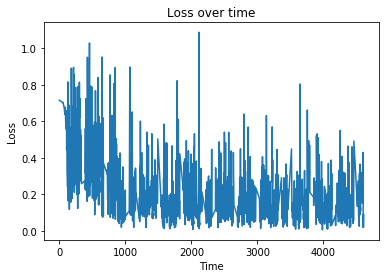

In [ ]:
# Your plotting code here
from matplotlib import pyplot as plt

plt.plot(np.array(times_train_loss) - times_train_loss[0], losses_train)
plt.title("Loss over time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.show()


___

### Predict

We generate a prediction on the pos_test_000072.png image

Calculate the output of the trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white (or equivalent binary color scheme), where white pixels represent things
we think are probably cancerous.

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Our trained network should be able to do better than that.

Actual image: ...

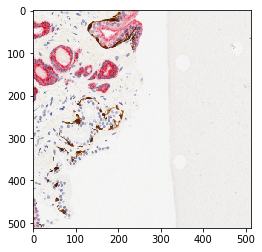

In [ ]:
# Code for testing prediction on an image
dataset = CancerDataset('/tmp/cancer_data', train=False)
img = dataset[172]
imgnp = img[0].numpy()
# Reshape
# toshow = np.dstack((imgnp[0], imgnp[1], imgnp[2]))
toshow = imgnp.transpose((1,2,0))
plt.imshow(toshow)
plt.show()

Ground truth: ...

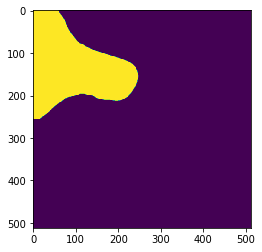

In [ ]:
# Code for testing prediction on an image
img = dataset[172]
# print(img[1].shape)
imgnp = img[1].numpy()
# Reshape
toshow = imgnp
plt.imshow(toshow)
plt.show()


Model prediction: ...

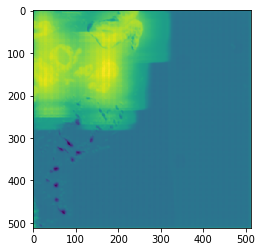

-1.6140761


In [ ]:
classimg = mod(img[0].unsqueeze(0).cuda())
classimg = classimg.squeeze(0)
pred0, pred1 = classimg[0], classimg[1]
toshow = pred1.cpu().detach().numpy()
plt.imshow(toshow)
plt.show()
print(toshow.mean())

### Plotted accuracies and losses

[0.6156993411748368, 0.5927767900241708, 0.04843626896858836, 1.0]


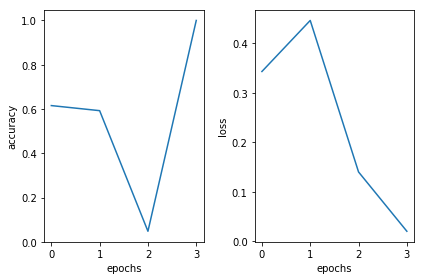

In [ ]:
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
print(accuracy_by_epoch)
ax1.plot(accuracy_by_epoch)
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax2.plot(losses_by_epoch)
ax2.set_xlabel("epochs")
ax2.set_ylabel("loss")
plt.tight_layout()
plt.show()